In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

### to change according to your machine
base_dir = os.path.expanduser("/media/data/tum")
path_training = os.path.join(base_dir, 'training.h5')
path_validation = os.path.join(base_dir, 'validation.h5')

fid_training = h5py.File(path_training,'r')
fid_validation = h5py.File(path_validation,'r')

## we can have a look at which keys are stored in the file
## you will get the return [u'label', u'sen1', u'sen2']
## sen1 and sen2 means the satellite images
print fid_training.keys()
print fid_validation.keys()

### get s1 image channel data
### it is not really loaded into memory. only the indexes have been loaded.
print "-" * 60
print "training part"
s1_training = fid_training['sen1']
print s1_training.shape
s2_training = fid_training['sen2']
print s2_training.shape
label_training = fid_training['label']
print label_training.shape

print "-" * 60
print "validation part"
s1_validation = fid_validation['sen1']
print s1_validation.shape
s2_validation = fid_validation['sen2']
print s2_validation.shape
label_validation = fid_validation['label']
print label_validation.shape

[u'label', u'sen1', u'sen2']
[u'label', u'sen1', u'sen2']
------------------------------------------------------------
training part
(352366, 32, 32, 8)
(352366, 32, 32, 10)
(352366, 17)
------------------------------------------------------------
validation part
(24119, 32, 32, 8)
(24119, 32, 32, 10)
(24119, 17)


In [18]:
## compute the quantity for each col
label_qty = np.sum(label_training, axis=0)

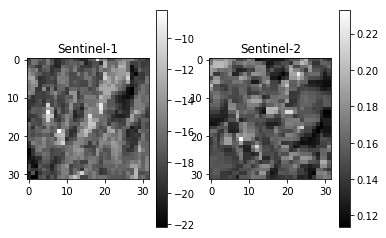

In [19]:
# visualization, plot the first pair of Sentinel-1 and Sentinel-2 patches of training.h5
import matplotlib.pyplot as plt
plt.plot(label_qty)

plt.subplot(121)
plt.imshow(10*np.log10(s1_training[0,:,:,4]),cmap=plt.cm.get_cmap('gray'));
plt.colorbar()
plt.title('Sentinel-1')

plt.subplot(122)
plt.imshow(s2_training[0,:,:,1],cmap=plt.cm.get_cmap('gray'));
plt.colorbar()
plt.title('Sentinel-2')

plt.show()

In [20]:
### simple classification example
### Training part

from sklearn.linear_model import SGDClassifier

train_s1 = s1_training
train_s2 = s2_training
train_label = label_training
clf = SGDClassifier()

train_y = np.argmax(train_label, axis=1)
classes = list(set(train_y))
batch_size = 100000
n_sampels = train_s1.shape[0]

for i in range(0, n_sampels, batch_size):
    ## this is an idea for batch training
    ## you can relpace this loop for deep learning methods
    if i % batch_size * 10 == 0:
        print("done %d/%d" % (i, n_sampels))
    start_pos = i
    end_pos = min(i + batch_size, n_sampels)
    train_s1_batch = np.asarray(train_s1[start_pos:end_pos, :, :, :])
    train_s2_batch = np.asarray(train_s2[start_pos:end_pos, :, :, :])
    cur_batch_size = train_s2_batch.shape[0]
    train_s1_batch = train_s1_batch.reshape((cur_batch_size, -1))
    train_s2_batch = train_s2_batch.reshape((cur_batch_size, -1))
    train_X_batch = np.hstack([train_s1_batch, train_s2_batch])
    label_batch = train_y[start_pos:end_pos]
    clf.partial_fit(train_X_batch, label_batch, classes=classes)

done 0/352366
done 100000/352366
done 200000/352366
done 300000/352366


In [21]:
### make a prediction on validation
pred_y = []
train_val_y = np.argmax(label_validation, axis=1)
batch_size = 10000
n_val_samples = s2_validation.shape[0]
for i in range(0, n_val_samples, batch_size):
    start_pos = i
    end_pos = min(i + batch_size, n_val_samples)
    val_s1_batch = np.asarray(s1_validation[start_pos:end_pos, :, :, :])
    val_s2_batch = np.asarray(s2_validation[start_pos:end_pos, :, :, :])
    cur_batch_size = val_s2_batch.shape[0]
    val_s1_batch = val_s1_batch.reshape((cur_batch_size, -1))
    val_s2_batch = val_s2_batch.reshape((cur_batch_size, -1))
    val_X_batch = np.hstack([val_s1_batch, val_s2_batch])
    tmp_pred_y = clf.predict(val_X_batch)
    pred_y.append(tmp_pred_y)
pred_y = np.hstack(pred_y)

In [16]:
from sklearn.metrics import classification_report
print classification_report(train_val_y, pred_y)

             precision    recall  f1-score   support

          0       0.06      0.07      0.07       256
          1       0.07      0.06      0.07      1254
          2       0.04      0.04      0.04      2353
          3       0.08      0.13      0.10       849
          4       0.04      0.00      0.00       757
          5       0.16      0.02      0.03      1906
          6       0.00      0.00      0.00       474
          7       0.24      0.46      0.32      3395
          8       0.20      0.01      0.02      1914
          9       0.10      0.06      0.08       860
         10       0.67      0.58      0.62      2287
         11       0.02      0.01      0.01       382
         12       0.00      0.00      0.00      1202
         13       0.45      0.28      0.35      2747
         14       0.01      0.00      0.01       202
         15       0.06      0.30      0.10       672
         16       0.53      0.90      0.67      2609

avg / total       0.25      0.28      0.24  

/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
